
The feature selection notebook does a filter followed by a wrapper. It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ...

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the ratio of goods to bads retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. 

BUT RIGHT NOW I'VE GOT A BUG SOMEWHERE: balance !=0 doesn't work when num_files > 1. I've got an index problem.

So you can run with multiple variables files only when balance=0, or you can run with only one variable file and set balance how you like.

In [1]:
#load libraries
#%pip install mlxtend

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
%matplotlib inline
start_time = dt.datetime.now()

In [4]:
# set some parameters
num_files = 1
num_filter = 100
num_wrapper = 30
# keep balance = 0 when num_files > 1 until I figure out this bug. Maybe somebody else can figure it out.
balance = 0
detect_rate = .03
index_name = 'record'
y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [5]:
%%time
for i in range(num_files):
    file_name = "vars"+str(i+1)+'.csv'
    df = pd.read_csv(file_name)
    print('work on file ', file_name)
    df = df[df[index_name] <= 833508] # remove the last two months as the out-of-time data (OOT)
    df = df[df[index_name] >= 38512] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods.set_index(index_name, inplace=True)
            goods.sort_index(inplace=True)
            goods = goods.iloc[goods_keep] # THERE'S SOMETHING WRONG HERE AND I CAN'T FIGURE IT OUT
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.set_index(index_name, inplace=True)
    df_sampled.sort_index(inplace=True)
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
        filter_score.columns = ['variable','score']   
        j = 0
        for column in df_sampled:
            filter_score.loc[j,'variable'] = column
            filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
            j = j+1
            
        filter_score.sort_values(by=['score'], ascending=False, inplace=True)
        vars_keep = list(filter_score['variable'][1:num_filter+1])
        print(filter_score.head(num_filter))
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        new = pd.DataFrame(np.zeros((num_vars+1,2)))
        new.columns = ['variable','score']   
        j = 0
        for column in df_sampled:
            new.loc[j,'variable'] = column
            new.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
            j = j+1
        
        new.sort_values(by=['score'], ascending=False, inplace=True)
        vars_keep = list(new['variable'][1:num_filter+1])
        print(new.head(num_filter))
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)
        filter_score = pd.concat([filter_score,new])
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()

work on file  vars1.csv
                   variable     score
9               fraud_label  1.000000
57        address_day_since  0.334096
85    fulladdress_day_since  0.333210
63         address_count_30  0.332725
91     fulladdress_count_30  0.332032
..                      ...       ...
98        name_dob_count_30  0.227623
168  firstname_dob_count_30  0.227274
50            ssn_day_since  0.227255
56             ssn_count_30  0.227027
288  ssn_name_dob_day_since  0.226598

[100 rows x 2 columns]
Wall time: 12min 8s


In [6]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)

In [7]:
filter_score.head(30)

,variable,score
9,fraud_label,1.000000
57,address_day_since,0.334096
85,fulladdress_day_since,0.333210
63,address_count_30,0.332725
91,fulladdress_count_30,0.332032
62,address_count_14,0.322252
90,fulladdress_count_14,0.321756
61,address_count_7,0.301445
89,fulladdress_count_7,0.301368
355,address_count_0_by_30,0.291997


In [8]:
filter_score.tail(10)

,variable,score
1451,ssn_name_fulladdressunique_count_forssn_zip5_14,0.0
1452,ssn_name_fulladdressunique_count_forssn_zip5_30,0.0
1453,ssn_name_fulladdressunique_count_forssn_zip5_60,0.0
1454,ssn_name_fulladdressunique_count_forssn_name_1,0.0
1455,ssn_name_fulladdressunique_count_forssn_name_3,0.0
1456,ssn_name_fulladdressunique_count_forssn_name_7,0.0
1457,ssn_name_fulladdressunique_count_forssn_name_14,0.0
1458,ssn_name_fulladdressunique_count_forssn_name_30,0.0
1459,ssn_name_fulladdressunique_count_forssn_name_60,0.0
1209,ssn_nameunique_count_forssn_3,0.0


In [9]:
filter_score.shape

(1473, 2)

In [10]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['address_day_since', 'fulladdress_day_since', 'address_count_30', 'fulladdress_count_30', 'address_count_14', 'fulladdress_count_14', 'address_count_7', 'fulladdress_count_7', 'address_count_0_by_30', 'fulladdress_count_0_by_30', 'fulladdressunique_count_fordob_homephone_60', 'fulladdressunique_count_forssn_name_fulladdress_60', 'fulladdressunique_count_forssn_name_60', 'fulladdressunique_count_forssn_lastname_60', 'fulladdressunique_count_forssn_zip5_60', 'fulladdressunique_count_forssn_fulladdress_60', 'fulladdressunique_count_forssn_60', 'fulladdressunique_count_forssn_name_dob_60', 'fulladdressunique_count_forname_fulladdress_60', 'fulladdressunique_count_forname_dob_60', 'fulladdressunique_count_forfulladdress_dob_60', 'fulladdressunique_count_fordob_homephone_30', 'fulladdressunique_count_forssn_name_fulladdress_30', 'fulladdressunique_count_forssn_name_30', 'fulladdressunique_count_forssn_lastname_30', 'fulladdressunique_count_forssn_zip5_30', 'fulladdressunique_c

In [11]:
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,address_day_since,fulladdress_day_since,address_count_30,fulladdress_count_30,address_count_14,fulladdress_count_14,address_count_7,fulladdress_count_7,address_count_0_by_30,fulladdress_count_0_by_30,...,ssn_dob_count_30,lastname_dob_count_30,name_dob_day_since,firstname_dob_day_since,name_dob_count_30,firstname_dob_count_30,ssn_day_since,ssn_count_30,ssn_name_dob_day_since,ssn_firstname_day_since
record,,,,,,,,,,,,,,,,,,,,,
38512,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,1,1,365.0,365.0,1,1,365.0,1,365.0,365.0
38513,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,1,1,365.0,365.0,1,1,365.0,1,365.0,365.0
38514,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,1,1,365.0,365.0,1,1,365.0,1,365.0,365.0
38515,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,1,1,365.0,365.0,1,1,365.0,1,365.0,365.0
38516,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,1,1,365.0,365.0,1,1,365.0,1,365.0,365.0


In [12]:
df_keep.shape

(794997, 100)

In [13]:
Y.head()

,fraud_label
record,
38512,0
38513,0
38514,0
38515,0
38516,0


In [14]:
Y = Y.values
X = df_keep

In [15]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 1:31:16.637710


In [16]:
print(X.shape,Y.shape)

(794997, 100) (794997, 1)


In [17]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [18]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [19]:
%%time
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
clf = RandomForestClassifier(n_estimators=5, n_jobs=-1) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.9s finished

[2022-03-02 20:53:15] Features: 1/30 -- score: 0.35425735678216963[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   55.3s finished

[2022-03-02 20:54:10] Features: 2/30 -- score: 0.5195020024377504[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   56.3s finished

[2022-03-02 20:55:07] Features: 3/30 -- score: 0.5213303151662894[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  97 

Wall time: 47min 49s



[2022-03-02 21:40:07] Features: 30/30 -- score: 0.5249869406233676

SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(n_estimators=5,
                                                           n_jobs=-1),
                          k_features=30, n_jobs=-1,
                          scoring=<function fdr at 0x0000026D70CBEA60>,
                          verbose=2)

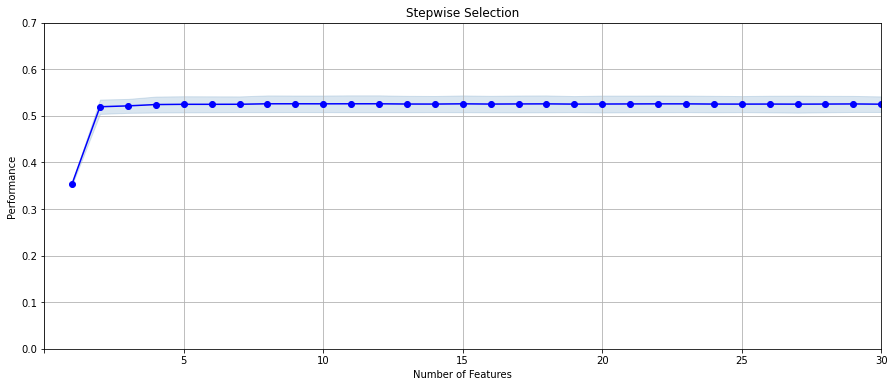

In [21]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.ylim([0., .7])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [22]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)","[0.351732543966568, 0.3567821695977712]",0.354257,"(fulladdress_count_30,)",0.010863,0.002525,0.002525
2,"(3, 97)","[0.5040919380114922, 0.5349120668640084]",0.519502,"(fulladdress_count_30, ssn_count_30)",0.066304,0.01541,0.01541
3,"(3, 10, 97)","[0.5063555632944454, 0.5363050670381334]",0.52133,"(fulladdress_count_30, fulladdressunique_count...",0.064431,0.014975,0.014975
4,"(2, 3, 10, 97)","[0.5070520633815079, 0.5413546926693366]",0.524203,"(address_count_30, fulladdress_count_30, fulla...",0.073796,0.017151,0.017151
5,"(2, 3, 10, 53, 97)","[0.5074003134250392, 0.5420511927563991]",0.524726,"(address_count_30, fulladdress_count_30, fulla...",0.074545,0.017325,0.017325
6,"(2, 3, 10, 16, 53, 97)","[0.5075744384468048, 0.5418770677346335]",0.524726,"(address_count_30, fulladdress_count_30, fulla...",0.073796,0.017151,0.017151
7,"(2, 3, 10, 16, 53, 95, 97)","[0.5079226884903361, 0.5417029427128678]",0.524813,"(address_count_30, fulladdress_count_30, fulla...",0.072672,0.01689,0.01689
8,"(2, 3, 10, 16, 31, 53, 95, 97)","[0.5079226884903361, 0.5437924429740554]",0.525858,"(address_count_30, fulladdress_count_30, fulla...",0.077168,0.017935,0.017935
9,"(2, 3, 10, 16, 17, 31, 53, 95, 97)","[0.5080968135121017, 0.5436183179522898]",0.525858,"(address_count_30, fulladdress_count_30, fulla...",0.076418,0.017761,0.017761
10,"(2, 3, 10, 16, 17, 24, 31, 53, 95, 97)","[0.5079226884903361, 0.5436183179522898]",0.525771,"(address_count_30, fulladdress_count_30, fulla...",0.076793,0.017848,0.017848


In [23]:
vars_final = list(vars_FS.loc[num_wrapper, 'feature_names'])
vars_final

['address_count_30',
 'fulladdress_count_30',
 'fulladdress_count_7',
 'fulladdress_count_0_by_30',
 'fulladdressunique_count_fordob_homephone_60',
 'fulladdressunique_count_forssn_name_60',
 'fulladdressunique_count_forssn_60',
 'fulladdressunique_count_forssn_name_dob_60',
 'fulladdressunique_count_forname_dob_60',
 'fulladdressunique_count_forfulladdress_dob_60',
 'fulladdressunique_count_fordob_homephone_30',
 'fulladdressunique_count_forssn_name_fulladdress_30',
 'fulladdressunique_count_forssn_lastname_30',
 'fulladdressunique_count_forssn_zip5_30',
 'fulladdressunique_count_forssn_fulladdress_30',
 'fulladdressunique_count_forname_fulladdress_30',
 'fulladdressunique_count_forname_dob_30',
 'fulladdressunique_count_fordob_homephone_14',
 'fulladdressunique_count_forssn_lastname_14',
 'fulladdressunique_count_forname_dob_14',
 'fulladdressunique_count_fordob_homephone_7',
 'fulladdressunique_count_forssn_7',
 'fulladdressunique_count_forssn_name_fulladdress_7',
 'fulladdressuniqu

In [24]:
vars_FS.to_csv('VarsFS.csv', index=False)

In [25]:
sfs.subsets_

{1: {'feature_idx': (3,),
  'cv_scores': array([0.35173254, 0.35678217]),
  'avg_score': 0.35425735678216963,
  'feature_names': ('fulladdress_count_30',)},
 2: {'feature_idx': (3, 97),
  'cv_scores': array([0.50409194, 0.53491207]),
  'avg_score': 0.5195020024377504,
  'feature_names': ('fulladdress_count_30', 'ssn_count_30')},
 3: {'feature_idx': (3, 10, 97),
  'cv_scores': array([0.50635556, 0.53630507]),
  'avg_score': 0.5213303151662894,
  'feature_names': ('fulladdress_count_30',
   'fulladdressunique_count_fordob_homephone_60',
   'ssn_count_30')},
 4: {'feature_idx': (2, 3, 10, 97),
  'cv_scores': array([0.50705206, 0.54135469]),
  'avg_score': 0.5242033780254223,
  'feature_names': ('address_count_30',
   'fulladdress_count_30',
   'fulladdressunique_count_fordob_homephone_60',
   'ssn_count_30')},
 5: {'feature_idx': (2, 3, 10, 53, 97),
  'cv_scores': array([0.50740031, 0.54205119]),
  'avg_score': 0.5247257530907192,
  'feature_names': ('address_count_30',
   'fulladdress_co

In [26]:
vars_final.append('index_name')
vars_final.append('y_name')
vars_final

['address_count_30',
 'fulladdress_count_30',
 'fulladdress_count_7',
 'fulladdress_count_0_by_30',
 'fulladdressunique_count_fordob_homephone_60',
 'fulladdressunique_count_forssn_name_60',
 'fulladdressunique_count_forssn_60',
 'fulladdressunique_count_forssn_name_dob_60',
 'fulladdressunique_count_forname_dob_60',
 'fulladdressunique_count_forfulladdress_dob_60',
 'fulladdressunique_count_fordob_homephone_30',
 'fulladdressunique_count_forssn_name_fulladdress_30',
 'fulladdressunique_count_forssn_lastname_30',
 'fulladdressunique_count_forssn_zip5_30',
 'fulladdressunique_count_forssn_fulladdress_30',
 'fulladdressunique_count_forname_fulladdress_30',
 'fulladdressunique_count_forname_dob_30',
 'fulladdressunique_count_fordob_homephone_14',
 'fulladdressunique_count_forssn_lastname_14',
 'fulladdressunique_count_forname_dob_14',
 'fulladdressunique_count_fordob_homephone_7',
 'fulladdressunique_count_forssn_7',
 'fulladdressunique_count_forssn_name_fulladdress_7',
 'fulladdressuniqu

In [27]:
X_final = df_keep.filter(vars_final, axis=1)
X_final.shape

(794997, 30)

In [28]:
X_final.to_csv('vars_final.csv', index=False)

In [31]:
vars_fs2 = vars_FS.columns
vars_fs2

Index(['feature_idx', 'cv_scores', 'avg_score', 'feature_names', 'ci_bound',
       'std_dev', 'std_err'],
      dtype='object')